# Application of Full waveform inversion by model extension (FWIME)
* ## Application to the "West Africa" section of the BP 2004 benchmark (Billette and Brandsberg-Dahl, 2004)

---
* Authors: Guillaume Barnier (barnier@gmail.com), Ettore Biondi (ebiondi@caltech.edu), and Stuart Farris (sfarris@sep.stanford.edu)
* Date: 05/12/2022
* Feel free to contact us for any questions or bugs to report

--- 
# About the authors
* [**Guillaume Barnier**](https://www.linkedin.com/in/guillaume-barnier/)
    * Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Research interests: seismic imaging, velocity model building, optimization of large-scale non-convex inverse problems, and machine learning 
    * Guillaume's [personal website](https://gbarnier.github.io)
* [**Ettore Biondi**](https://www.linkedin.com/in/ettore-biondi/)
    * Postdoctoral Researcher at California Institute of Technology in its Seismological Laboratory working within Professor Zhongwen Zhan's research group
    * Former Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Passionate about geophysics, computer science, chemistry, and Earth science
    * Ettore's [personal page](http://www.seismolab.caltech.edu/biondi_e.html)
* [**Stuart Farris**](https://www.linkedin.com/in/stuart-farris/)
    * Ph.D. student at Stanford University in the Stanford Exporation Project (SEP) group
    * Research interests: Carbon sequestration, machine learning, velocity model building using deep learning, seismic imaging, and inverse problems
    * Currently an AI resident at [X Development](https://x.company)
   
---
# Useful links
* Our YouTube channel ["egoptimization"](https://www.youtube.com/channel/UCjloQO0H6JnddXoB017mcog)
* Stanford Exploration project (SEP) [website](https://sep.sites.stanford.edu) and [YouTube channel](https://www.youtube.com/channel/UCk8h7bfpd-vl_CWCDLHxHzA)
* Ettore's Ph.D. [thesis](http://sepwww.stanford.edu/data/media/public/sep/ettore/pdfs/thesis/thesis_Ettore.pdf) and Ph.D. [defense](https://www.youtube.com/watch?v=cmhhm4HW070&t=2645s) at Stanford University
* Guillaume's Ph.D. [thesis](http://sepwww.stanford.edu/data/media/public/sep/gbarnier/Guillaume_thesis_sep_website.pdf) and Ph.D. [defense](https://www.youtube.com/watch?v=vv9krmVRkMo&t=2309s) at Stanford University

---
# Description
This Jupyter notebook allows you to reproduce the results proposed in Barnier et al. (2022) using the BP benchmark synthetic model (Billette and Brandsberg-Dahl, 2004). The notebook is organized as follows:
 1. **Setup**:
    * Import libraries
    * Read/load initial/true velocity models (non-reproducible)
    * Read/load the "target" velocity model, which is the FWIME inverted model shown in Barnier et al. (2022) that this notebook will allow you to reproduce
    * Pad velocity models for FD modeling
    * Create mask for gradient
 2. **Conventional data-space mutli-scale FWI**
     * Create wavelet sources and data 
     * Display wavelet time series, wavelet spectrum, and a subset of the dataset
     * Launch inversion on each band
     * Display objective functions and inverted model
 3. **FWIME**
     * For each inversion on a given spline grid: 
         * Map velocity model on current spline grid
         * Create bounds for the mibn/max velocity values on current spline grid
         * Launch inversion on current spline grid
 4. **Results analysis**
      * Display FWIME results (objective functions and inverted velocity models)
 5. **References**

# Summary of main results
* In this notebook, you will be able to reproduce the results from the numerical example proposed in Barnier et al. (2022) on the well-known BP 2004 benchmark model
* In addition to the series of instructions which will allow you to reproduce our resutls, we provide:
    * The initial model, which is very inaccruate (no salt)
    * The true model 
    * The FWI inverted model shown in Barnier (2022) using unrealistic low-frequency energy. You will reproduce this result in this notebook
    * The FWI inverted model shown in Barnier (2022) using data whose frequency content is restricted to the 3-8 Hz band. You will also reproduce this result to see how poorly conventional FWI performs in this scenario
    * The "target" FWIME model, which is the final FWIME inverted model shown in Barnier et al. (2022). At the end of the notebook, you should be able to recover the exact same model
* Unfortunately, as shown in the paper, FWIME could not retrieve a solution as accurate as FWI using unrealistic low frequency. However, the inverted model still provides some uplift compared to conventional FWI using 3-8 Hz
    



## Display velocity models to summarize results from paper

env: ACO_GPU_PACK=/opt/acoustic_2d/local/


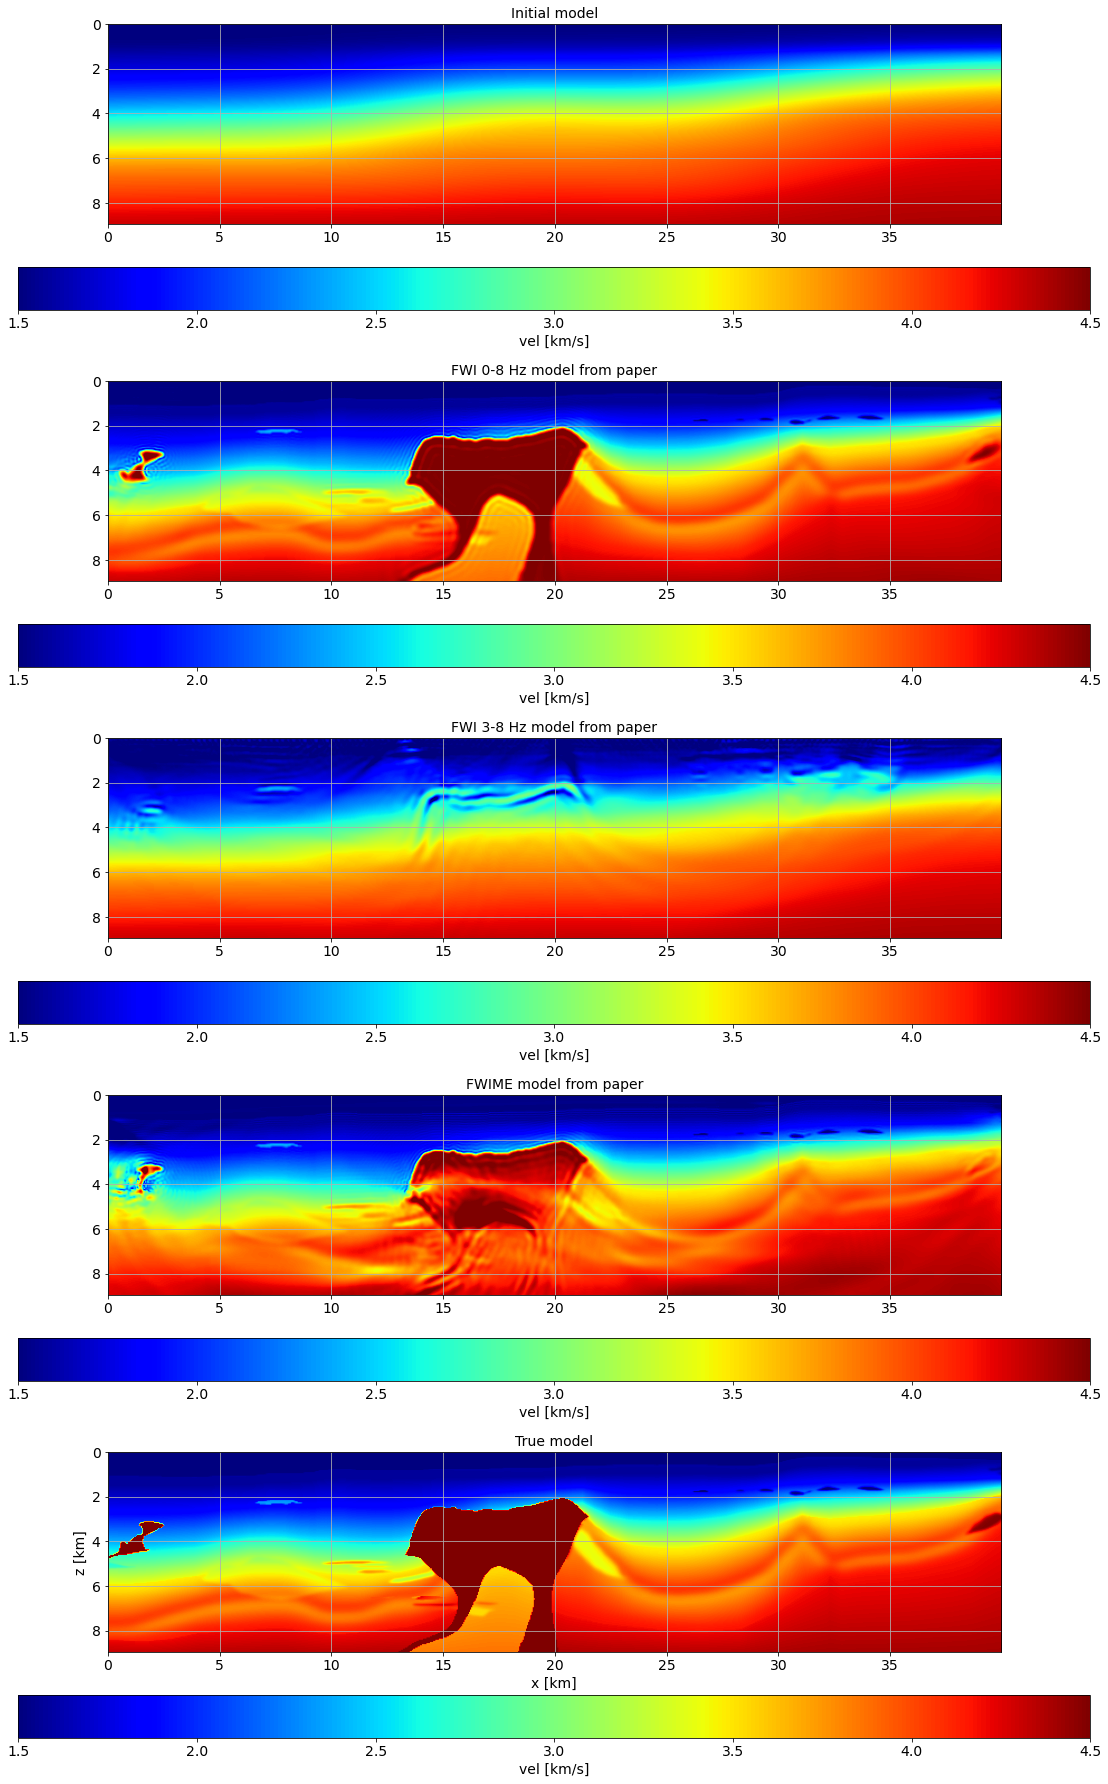

In [1]:
# Import libraries
import genericIO
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

# Set the path for the executables
%env ACO_GPU_PACK=/opt/acoustic_2d/local/

# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel_non_repro/BP_West_Africa-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel_non_repro/BP_West_Africa-initVel1.H")
vel_fwime_paper = genericIO.defaultIO.getVector("vel_paper/BP_West_Africa_fwime_vel_paper.H")
vel_fwi_0_8_paper = genericIO.defaultIO.getVector("vel_paper/BP_West_Africa_fwi_0_8_vel_paper.H")
vel_fwi_3_8_paper = genericIO.defaultIO.getVector("vel_paper/BP_West_Africa_fwi_3_8_vel_paper.H")

# Convert to np arrays
vel_fwime_paper_nd = vel_fwime_paper.getNdArray()
vel_fwi_0_8_paper_nd = vel_fwi_0_8_paper.getNdArray()
vel_fwi_3_8_paper_nd = vel_fwi_3_8_paper.getNdArray()
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get model dimensions
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

fig, axs = plt.subplots(5, 1, figsize=(25, 25))

# Plot initial velocity model
img0 = axs[0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1)
axs[0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0, ax=axs[0], orientation="horizontal", label="vel [km/s]", aspect=25)
axs[0].grid()

# Plot FWI 0-8 Hz velocity model
img1 = axs[1].imshow(vel_fwi_0_8_paper_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1)
axs[1].set_title("FWI 0-8 Hz model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1, ax=axs[1], orientation="horizontal", label="vel [km/s]", aspect=25)
axs[1].grid()

# Plot FWI 3-8 Hz velocity model
img2 = axs[2].imshow(vel_fwi_3_8_paper_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1)
axs[2].set_title("FWI 3-8 Hz model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2, ax=axs[2], orientation="horizontal", label="vel [km/s]", aspect=25)
axs[2].grid()

# Plot FWIME velocity model
img3 = axs[3].imshow(vel_fwime_paper_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1)
axs[3].set_title("FWIME model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img3, ax=axs[3], orientation="horizontal", label="vel [km/s]", aspect=25)
axs[3].grid()

# Plot FWIME velocity model
img4 = axs[4].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1)
axs[4].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img4, ax=axs[4], orientation="horizontal", label="vel [km/s]", aspect=25)
axs[4].grid()


plt.tight_layout()

# Computational time
To give you a sense of the computational time you should expect for the inversions proposed in this notebook, here are some estimations:

1. **Data-space multi-scale FWI**:
    * We use four frequency bands 
    * We conduct 1000 L-BFGS iterations per frequency band
    * One L-BFGS iteration of FWI takes approximatelty 1 min on 4 x V100 Tesla NVIDIA GPUs
    * The inversion on **one frequency band** takes approximately **12 hours**
2. **Model-space multi-scale FWIME**:
    * We use 7 spline grids
    * One L-BFGS iteration of FWIME takes approximatelty 85 min on 4 x V100 Tesla NVIDIA GPUs
    * For instance, the inversion on the first spline requires 80 L-BFGS iterations of FWIME, which corresponds to a compute time of approximately **100 hours**
    * **Disclaimer**: The parameter values used in the paper and in this notebook are very conservative. Our goal was to "make it work" before trying to reduce the computational cost, as explained in Barnier et al. (2022)
    * You are welcome to try to play with/adjust the FWIME parameters (in the "par" directory) to reduce the computational cost of FWIME, and observe their effects on the FWIME inverted model
        * Decrease the number of linear iterations for the varaible projection step by setting "nIterLin" to a smaller value
        * Decrease the number of L-BFGS iterations on each spline grid
        * Decrease the extension length "nExt" from 101 to a smaller value
        * Try with a different model extension. In our paper, we use time lags but you can try horizontal subsurface offsets by setting extension=offset in the "par" file 

# 1. Setup

## Velocity models

In [2]:
# Read velocity models
vel_true = genericIO.defaultIO.getVector("vel_non_repro/BP_West_Africa-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel_non_repro/BP_West_Africa-initVel1.H")

# Get numpy array + hypecube info
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
vel_hyper = vel_true.getHyper()

# Get axes information
oz = vel_hyper.getAxis(1).o
dz = vel_hyper.getAxis(1).d
nz = vel_hyper.getAxis(1).n
ox = vel_hyper.getAxis(2).o
dx = vel_hyper.getAxis(2).d
nx = vel_hyper.getAxis(2).n

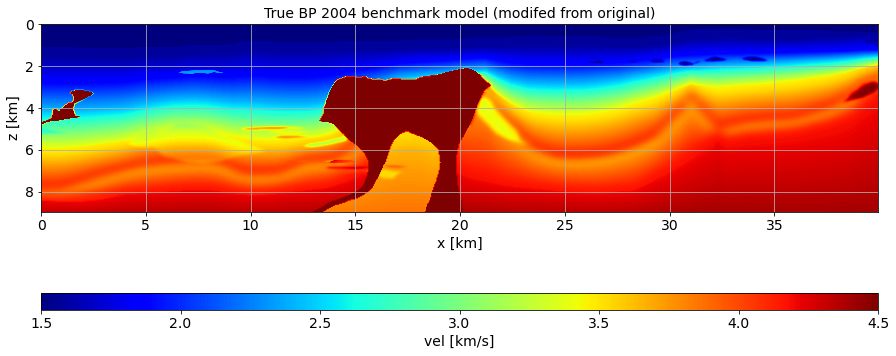

In [3]:
# Plot true velocity model
plt.figure(figsize=(15,10))
plt.imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("True BP 2004 benchmark model (modifed from original)"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

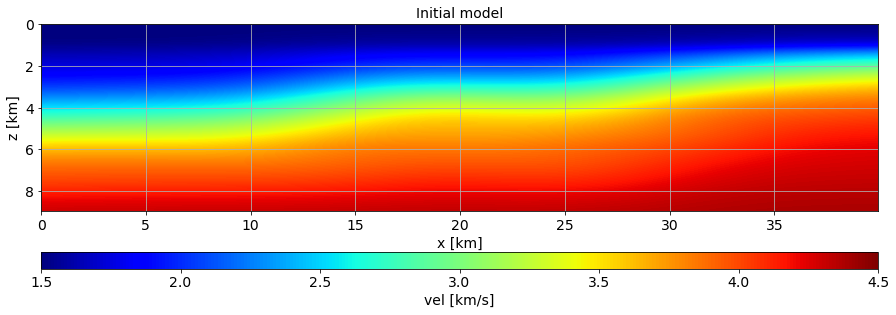

In [4]:
# Plot initial velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_init_nd.T,cmap='jet', vmin=1.5, vmax=4.5, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## FWIME inverted velocity model from paper ("target" model)
* These is the FWIME inverted velocity model presented in Barnier et al. (2022)
* You should recover this solution after running this Jupyter notebook

In [5]:
# Read FWIME velocity model
vel_target = genericIO.defaultIO.getVector("vel_paper/BP_West_Africa_fwime_vel_paper.H")

# Get numpy array + hypercube info
vel_target_nd = vel_target.getNdArray()


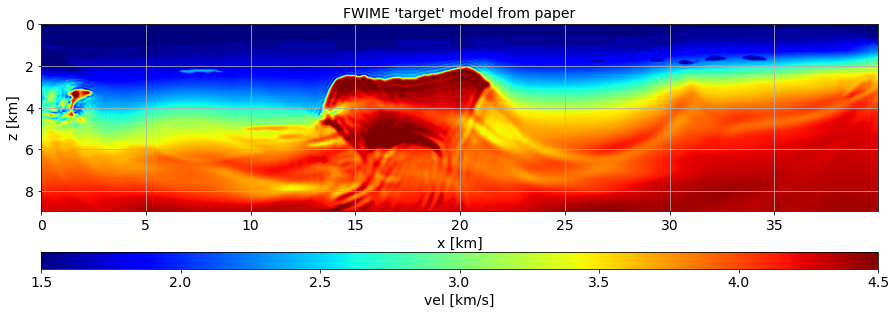

In [6]:
# Plot FWIME velocity model
plt.figure(figsize=(15,5))
plt.imshow(vel_target_nd.T,cmap='jet', vmin=1.5, vmax=4.5, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("FWIME 'target' model from paper"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Pad velocity models
In this numerical example, we use absorbing boundaries in all directions

In [8]:
%%bash

# Pad both initial and true velocity models
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=vel_non_repro/BP_West_Africa-trueVel.H data=vel/BP_West_Africa-trueVel.pad.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=vel_non_repro/BP_West_Africa-initVel1.H data=vel/BP_West_Africa-initVel1.pad.H

 
------------------------ Model padding program --------------------
Original nz = 180 [samples]
Original nx = 800 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 58 [samples]
xPadMinus = 50 [samples]
xPadPlus = 62 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 298 [samples including padding and FAT]
New nx = 922 [samples including padding and FAT]
-------------------------------------------------------------------
 
 
------------------------ Model padding program --------------------
Original nz = 180 [samples]
Original nx = 800 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 58 [samples]
xPadMinus = 50 [samples]
xPadPlus = 62 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 298 [samples including padding and FAT]
New nx = 922 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Masks for gradient

* We generate different masks for the inversions on the different spline grids 
* The same way we would create different masks for conventional data-space multi-scale FWI
* The mask only restrains the inversion from updating the water layer
* The "finer" the grid, the sharper the mask is in the vicinity of the water bottom

In [9]:
%%bash

# Create dummy velocity model
Vel n1=180 n2=800 n3=1 d1=1 d2=1 d3=1 o1=0.0 o2=0.0 o3=0.0 vc=1 > temp/temp2.H &&\
echo "d1=0.05 d2=0.05 d3=0.05" >> temp/temp2.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/temp2.H data=temp/temp2.pad.H &&\
# Create mask
${ACO_GPU_PACK}/bin/maskGradientMain.py bufferUp=0.3 bufferDown=0.3 taperExp=2 wbShift=0.3 vel=vel/BP_West_Africa-trueVel.pad.H model=temp/temp2.pad.H data=temp/temp3.H mask=temp/tempMask1.H &&\
Window3d n1=180 f1=55 n2=800 f2=55 < temp/tempMask1.H > temp/tempMask3.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/tempMask3.H data=vel/BP_West_Africa-gradientMask1.pad.H


 
------------------------ Model padding program --------------------
Original nz = 180 [samples]
Original nx = 800 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 58 [samples]
xPadMinus = 50 [samples]
xPadPlus = 62 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 298 [samples including padding and FAT]
New nx = 922 [samples including padding and FAT]
-------------------------------------------------------------------
 
--- User has not provided a gradient mask file ---
--- Automatically generating the mask from the provided parameters ---
 
------------------------ Model padding program --------------------
Original nz = 180 [samples]
Original nx = 800 [samples]
 
zPadMinus = 50 [samples]
zPadPlus = 58 [samples]
xPadMinus = 50 [samples]
xPadPlus = 62 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 298 [samples including padding and FAT]
New nx = 922 [samples including padding and FAT]
------------------------------------------------------------------

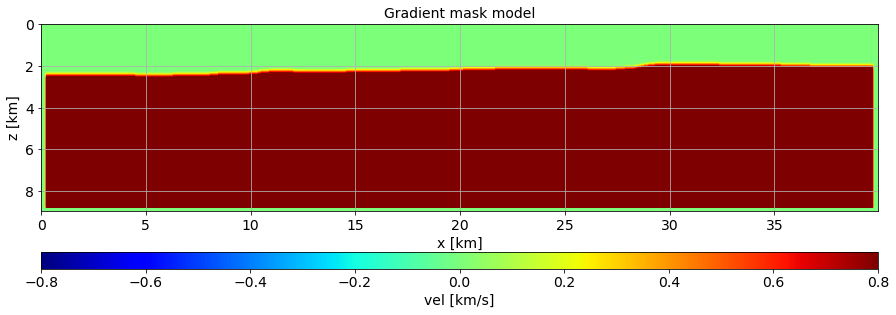

In [10]:
# Display mask on spline 1
gradient_mask1 = genericIO.defaultIO.getVector("vel/BP_West_Africa-gradientMask1.pad.H")
gradient_mask1_nd = gradient_mask1.getNdArray()
plt.figure(figsize=(15,5))
plt.imshow(gradient_mask1_nd.T,cmap='jet', vmin=-0.8, vmax=0.8, extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect="equal")
plt.title("Gradient mask model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
plt.colorbar(orientation="horizontal", label="vel [km/s]", aspect=50)
plt.grid()
plt.show()

## Create dummy velocity model 
We create this dummy file to pass the model dimension and hypercube information to the FWIME script and to the spline operator 

In [11]:
%%bash
Cp vel/BP_West_Africa-trueVel.pad.H vel/BP_West_Africa_velDummy.pad.H

# 2. Conventional data-space multi-scale FWI 0-8 Hz

## Create wavelets

For simplicity, we generate 5 wavelets and datasets corresponding to each frequency band instead of generating one dataset and bandpassing every time

In [12]:
%%bash

############ Wavelets for conventional FWI ############
# For simplicity, we generate one wavelet and one dataset per frequency band
# 0-2 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_West_Africa-fwi-0-8.p timeDelay=2.0 f1=0 f2=1 f3=1 f4=2 type=ali wavelet=wav/BP_West_Africa-wav-fwi-0-2.H &&\

# 0-3 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_West_Africa-fwi-0-8.p timeDelay=2.0 f1=0 f2=1.5 f3=1.5 f4=3 type=ali wavelet=wav/BP_West_Africa-wav-fwi-0-3.H &&\

# 0-4 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_West_Africa-fwi-0-8.p timeDelay=2.0 f1=0 f2=1.5 f3=2 f4=4 type=ali wavelet=wav/BP_West_Africa-wav-fwi-0-4.H &&\

# 0-5 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_West_Africa-fwi-0-8.p timeDelay=2.0 f1=0 f2=1.5 f3=3 f4=5 type=ali wavelet=wav/BP_West_Africa-wav-fwi-0-5.H &&\

# 0-8 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_West_Africa-fwi-0-8.p timeDelay=2.0 f1=0 f2=1.5 f3=5 f4=7.5 type=ali wavelet=wav/BP_West_Africa-wav-fwi-0-8.H 



## Display wavelets time series

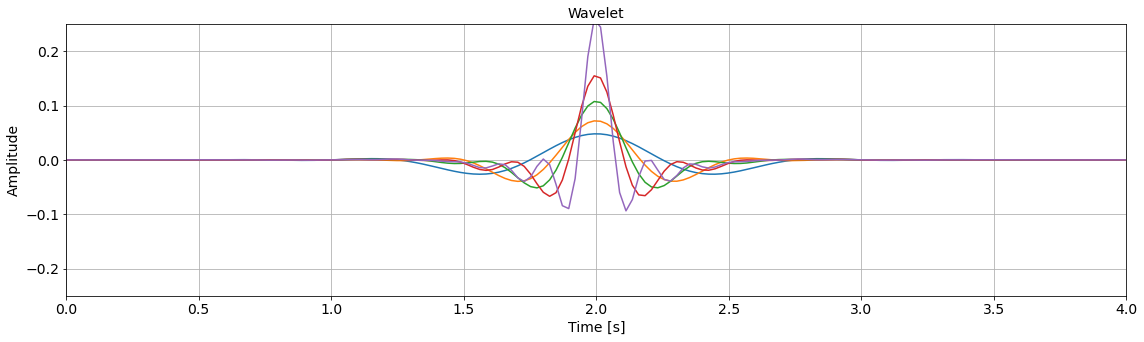

In [16]:
# Read wavelets 
wav_0_2 = genericIO.defaultIO.getVector("wav/BP_West_Africa-wav-fwi-0-2.H")
wav_0_3 = genericIO.defaultIO.getVector("wav/BP_West_Africa-wav-fwi-0-3.H")
wav_0_4 = genericIO.defaultIO.getVector("wav/BP_West_Africa-wav-fwi-0-4.H")
wav_0_5 = genericIO.defaultIO.getVector("wav/BP_West_Africa-wav-fwi-0-5.H")
wav_0_8 = genericIO.defaultIO.getVector("wav/BP_West_Africa-wav-fwi-0-8.H")

# Get numpy arrays
wav_0_2_nd = wav_0_2.getNdArray()
wav_0_3_nd = wav_0_3.getNdArray()
wav_0_4_nd = wav_0_4.getNdArray()
wav_0_5_nd = wav_0_5.getNdArray()
wav_0_8_nd = wav_0_8.getNdArray()

# Get dimensions
wavelet_hyper = wav_0_2.getHyper()
time_axis = wavelet_hyper.getAxis(1)
nt = time_axis.n
ot = time_axis.o
dt = time_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(time_range, wav_0_2_nd)
plt.plot(time_range, wav_0_3_nd)
plt.plot(time_range, wav_0_4_nd)
plt.plot(time_range, wav_0_5_nd)
plt.plot(time_range, wav_0_8_nd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-0.25, 0.25])
plt.xlim([0, 4])
plt.grid()
plt.show()



## Plot wavelet spectra

In [17]:
%%bash

############### Create wavelet spectra ###############
Scale < wav/BP_West_Africa-wav-fwi-0-2.H | Spectra mag=dBnorm > temp/t1.H &&\
Scale < wav/BP_West_Africa-wav-fwi-0-3.H | Spectra mag=dBnorm > temp/t2.H &&\
Scale < wav/BP_West_Africa-wav-fwi-0-4.H | Spectra mag=dBnorm > temp/t3.H &&\
Scale < wav/BP_West_Africa-wav-fwi-0-5.H | Spectra mag=dBnorm > temp/t4.H &&\
Scale < wav/BP_West_Africa-wav-fwi-0-8.H | Spectra mag=dBnorm > temp/t5.H &&\
Cat axis=2 temp/t1.H temp/t2.H temp/t3.H temp/t4.H temp/t5.H > wav/BP_West_Africa_temp_spec.H


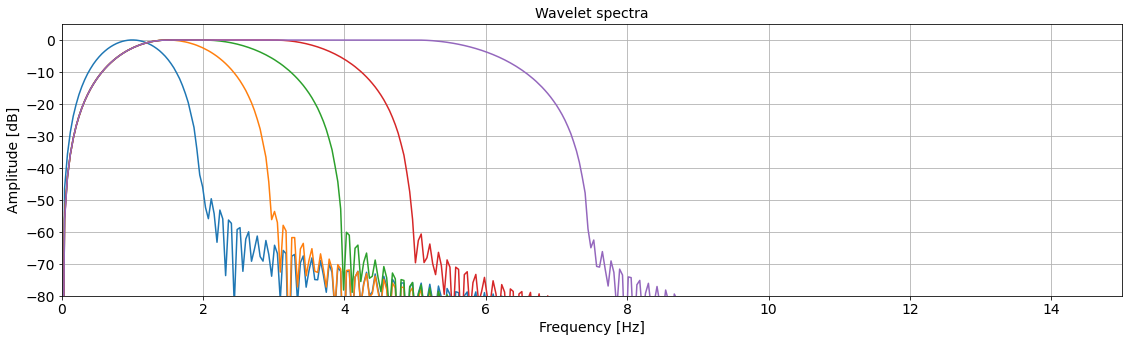

In [18]:
# Read spectra
spectra = genericIO.defaultIO.getVector("wav/BP_West_Africa_temp_spec.H")
spectra_Nd = spectra.getNdArray()
spectraHyper = spectra.getHyper()

# Read dimensions
freq_axis = spectraHyper.getAxis(1)
nf = freq_axis.n
of = freq_axis.o
df = freq_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
freq_range = np.linspace(of, of+(nf-1)*df, nf)
plt.plot(freq_range, spectra_Nd.T)
plt.title('Wavelet spectra'), plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude [dB]")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-80, 5])
plt.xlim([0, 15])
plt.grid()
plt.show()


## Generate data
In this notebook, we generate noise-free acoustic isotropic constant-density pressure data 

In [ ]:
%%bash

# 0-2 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_West_Africa-fwi-0-8.p vel=vel/BP_West_Africa-trueVel.pad.H model=wav/BP_West_Africa-wav-fwi-0-2.H data=dat/BP_West_Africa-fwi-dat-0-2.H info=0 &&\

# 0-3 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_West_Africa-fwi-0-8.p vel=vel/BP_West_Africa-trueVel.pad.H model=wav/BP_West_Africa-wav-fwi-0-3.H data=dat/BP_West_Africa-fwi-dat-0-3.H info=0 &&\

# 0-4 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_West_Africa-fwi-0-8.p vel=vel/BP_West_Africa-trueVel.pad.H model=wav/BP_West_Africa-wav-fwi-0-4.H data=dat/BP_West_Africa-fwi-dat-0-4.H info=0 &&\

# 0-5 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_West_Africa-fwi-0-8.p vel=vel/BP_West_Africa-trueVel.pad.H model=wav/BP_West_Africa-wav-fwi-0-5.H data=dat/BP_West_Africa-fwi-dat-0-5.H info=0 

# 0-8 Hz
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_West_Africa-fwi-0-8.p vel=vel/BP_West_Africa-trueVel.pad.H model=wav/BP_West_Africa-wav-fwi-0-8.H data=dat/BP_West_Africa-fwi-dat-0-8.H info=0 

## Read and display data

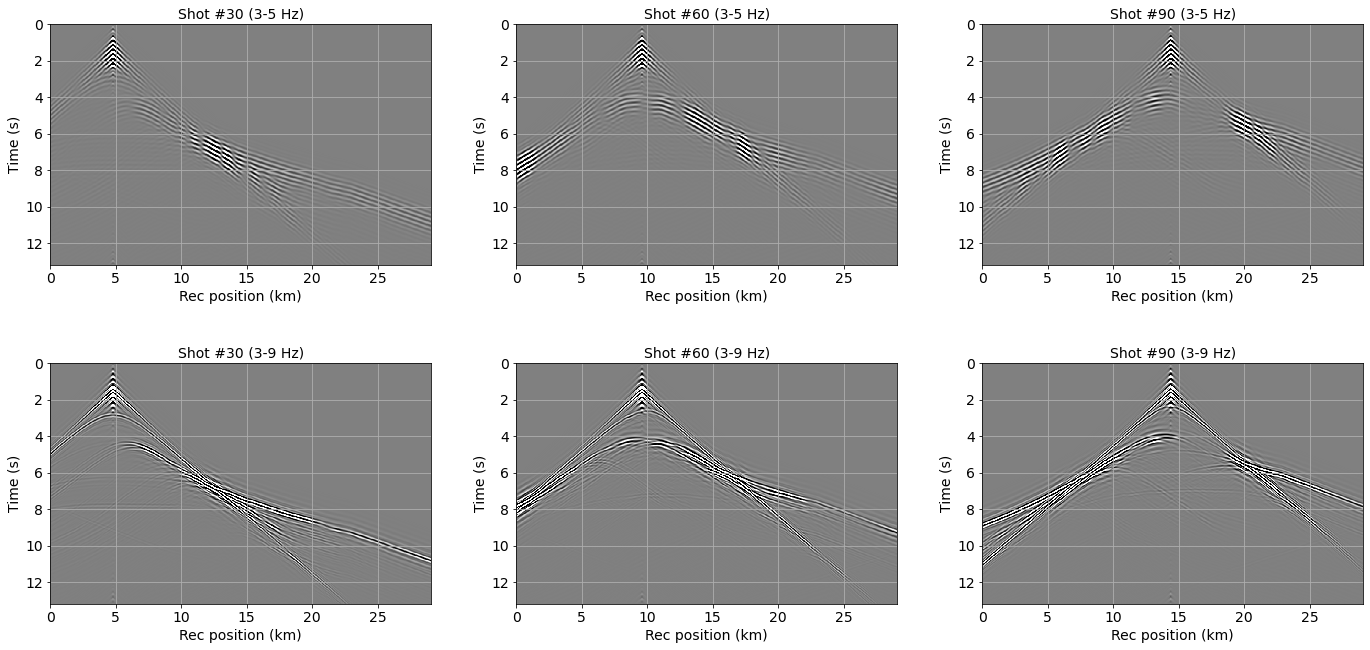

In [31]:
# Read data
data_0_2 = genericIO.defaultIO.getVector("dat/BP_West_Africa-fwi-dat-0-2.H")
data_0_3 = genericIO.defaultIO.getVector("dat/BP_West_Africa-fwi-dat-0-3.H")
data_0_4 = genericIO.defaultIO.getVector("dat/BP_West_Africa-fwi-dat-0-4.H")
data_0_5 = genericIO.defaultIO.getVector("dat/BP_West_Africa-fwi-dat-0-5.H")
data_0_8 = genericIO.defaultIO.getVector("dat/BP_West_Africa-fwi-dat-0-8.H")

# Display data
data_0_2_nd = data_0_2.getNdArray()
data_0_3_nd = data_0_3.getNdArray()
data_0_4_nd = data_0_4.getNdArray()
data_0_5_nd = data_0_5.getNdArray()
data_0_8_nd = data_0_8.getNdArray()

# Clipping
pclip=98
clip = np.percentile(np.abs(data_0_8_nd), pclip)

# Dimensions
o_rec = data_0_8.getHyper().getAxis(2).o
d_rec = data_0_8.getHyper().getAxis(2).d
n_rec = data_0_8.getHyper().getAxis(2).n
rec_range = np.linspace(o_rec, o_rec+(n_rec-1)*d_rec, n_rec)

# Display shot gathers
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# First frequency band: 0-2 Hz
shot1 = 30
axs[0,0].pcolormesh(rec_range, time_range, data_0_2[shot1].T,vmin=-clip,vmax=clip)
axs[0,0].invert_yaxis()
axs[0,0].grid()
axs[0,0].set_ylabel('Time (s)')
axs[0,0].set_xlabel('Rec position (km)')
axs[0,0].set_title('Shot #' + str(shot1) + " (0-2 Hz)")

shot2 = 60
axs[0,1].pcolormesh(rec_range, time_range, data_0_2[shot2].T,vmin=-clip,vmax=clip)
axs[0,1].invert_yaxis()
axs[0,1].grid()
axs[0,1].set_ylabel('Time (s)')
axs[0,1].set_xlabel('Rec position (km)')
axs[0,1].set_title('Shot #' + str(shot2) + " (0-2 Hz)")

shot3 = 90
axs[0,2].pcolormesh(rec_range, time_range, data_0_2[shot3].T,vmin=-clip,vmax=clip)
axs[0,2].invert_yaxis()
axs[0,2].grid()
axs[0,2].set_ylabel('Time (s)')
axs[0,2].set_xlabel('Rec position (km)')
axs[0,2].set_title('Shot #' + str(shot3) + " (0-2 Hz)")

# Last frequency band: 0-8 Hz
axs[1,0].pcolormesh(rec_range, time_range, data_0_8[shot1].T,vmin=-clip,vmax=clip)
axs[1,0].invert_yaxis()
axs[1,0].grid()
axs[1,0].set_ylabel('Time (s)')
axs[1,0].set_xlabel('Rec position (km)')
axs[1,0].set_title('Shot #' + str(shot1) + " (3-8 Hz)")

axs[1,1].pcolormesh(rec_range, time_range, data_0_8[shot2].T,vmin=-clip,vmax=clip)
axs[1,1].invert_yaxis()
axs[1,1].grid()
axs[1,1].set_ylabel('Time (s)')
axs[1,1].set_xlabel('Rec position (km)')
axs[1,1].set_title('Shot #' + str(shot2) + " (3-8 Hz)")

axs[1,2].pcolormesh(rec_range, time_range, data_0_8[shot3].T,vmin=-clip,vmax=clip)
axs[1,2].invert_yaxis()
axs[1,2].grid()
axs[1,2].set_ylabel('Time (s)')
axs[1,2].set_xlabel('Rec position (km)')
axs[1,2].set_title('Shot #' + str(shot3) + " (0-8 Hz)")

plt.tight_layout(pad=3.0)
plt.show()

## Conventional data-space multi-scale FWI
* We apply conventional data-space multi-scale FWI using 6 frequency bands: 0-2 Hz, 0-3 Hz, 0-4 Hz, 0-5 Hz, and 0-8 Hz
* We show that FWI converges to an accurate solution
* The approximate computational time for one L-BFGS iteration of FWI is 1 min using 4 x V100 Tesla NVIDIA GPUs, so approximately **8 hours per frequency band** (500 iterations per band)

In [25]:
%%bash

# Inversion on 3-5 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_North_Sea-fwi-3-9.p sources=wav/BP_North_Sea-fwi-wav-3-5.H vel=vel/BP_North_Sea-initVel1.pad.H data=dat/BP_North_Sea-fwi-dat-3-5.H nIter=500 folder=inv/BP_North_Sea-fwi-3-5Hz minBound=1.3 maxBound=5.0 solver=lbfgs


Process is terminated.


In [ ]:
%%bash

# Inversion on 3-6 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_North_Sea-fwi-3-9.p sources=wav/BP_North_Sea-fwi-wav-3-6.H vel=inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_inv_mod.H data=dat/BP_North_Sea-fwi-dat-3-6.H nIter=500 folder=inv/BP_North_Sea-fwi-3-6Hz minBound=1.3 maxBound=5.0 solver=lbfgs

In [ ]:
%%bash

# Inversion on 3-7 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_North_Sea-fwi-3-9.p sources=wav/BP_North_Sea-fwi-wav-3-7.H vel=inv/BP_North_Sea-fwi-3-6Hz/BP_North_Sea-fwi-3-6Hz_inv_mod.H data=dat/BP_North_Sea-fwi-dat-3-7.H nIter=500 folder=inv/BP_North_Sea-fwi-3-7Hz minBound=1.3 maxBound=5.0 solver=lbfgs

In [ ]:
%%bash

# Inversion on 3-9 Hz
${ACO_GPU_PACK}/bin/fwiMain.py par=par/BP_North_Sea-fwi-3-9.p sources=wav/BP_North_Sea-fwi-wav-3-9.H vel=inv/BP_North_Sea-fwi-3-7Hz/BP_North_Sea-fwi-3-7Hz_inv_mod.H data=dat/BP_North_Sea-fwi-dat-3-9.H nIter=500 folder=inv/BP_North_Sea-fwi-3-9Hz minBound=1.3 maxBound=5.0 solver=lbfgs

## Display FWI results

### Objective functions

In [ ]:
############# Objective functions #############
# Read file 
obj_fwi_3_5 = genericIO.defaultIO.getVector("inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_obj.H")
obj_fwi_3_6 = genericIO.defaultIO.getVector("inv/BP_North_Sea-fwi-3-6Hz/BP_North_Sea-fwi-3-6Hz_obj.H")
obj_fwi_3_7 = genericIO.defaultIO.getVector("inv/BP_North_Sea-fwi-3-7Hz/BP_North_Sea-fwi-3-7Hz_obj.H")
obj_fwi_3_9 = genericIO.defaultIO.getVector("inv/BP_North_Sea-fwi-3-9Hz/BP_North_Sea-fwi-3-9Hz_obj.H")

# Convert to numpy array
obj_fwi_3_5_nd = obj_fwi_3_5.getNdArray()
obj_fwi_3_6_nd = obj_fwi_3_6.getNdArray()
obj_fwi_3_7_nd = obj_fwi_3_7.getNdArray()
obj_fwi_3_9_nd = obj_fwi_3_9.getNdArray()

# Plot 
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(obj_fwi_3_5_nd/obj_fwi_3_5_nd[0])
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.subplot(122)
plt.plot(np.log10(obj_fwi_3_5_nd/obj_fwi_3_5_nd[0]))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()


### FWI inverted models for each frequency band

In [ ]:
%%bash

# Remove padding from inverted models
Window3d n1=140 f1=55 n2=728 f2=55 < inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_obj.H > inv/BP_North_Sea_inv_mod_3_5.H &&\
Window3d n1=140 f1=55 n2=728 f2=55 < inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_obj.H > inv/BP_North_Sea_inv_mod_3_6.H &&\
Window3d n1=140 f1=55 n2=728 f2=55 < inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_obj.H > inv/BP_North_Sea_inv_mod_3_7.H &&\
Window3d n1=140 f1=55 n2=728 f2=55 < inv/BP_North_Sea-fwi-3-5Hz/BP_North_Sea-fwi-3-5Hz_obj.H > inv/BP_North_Sea_inv_mod_3_9.H 
    

In [ ]:
# Read inverted models

model_3_5 = genericIO.defaultIO.getVector("inv/BP_North_Sea_inv_mod_3_5.H")
model_3_6 = genericIO.defaultIO.getVector("inv/BP_North_Sea_inv_mod_3_6.H")
model_3_7 = genericIO.defaultIO.getVector("inv/BP_North_Sea_inv_mod_3_7.H")
model_3_9 = genericIO.defaultIO.getVector("inv/BP_North_Sea_inv_mod_3_9.H")

# Convert to numpy arrays
model_3_5_nd = model_3_5.getNdArray()
model_3_6_nd = model_3_6.getNdArray()
model_3_7_nd = model_3_7.getNdArray()
model_3_9_nd = model_3_9.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot Initial velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()

# Plot 4-6 Hz velocity model
img0_1 = axs[0,1].imshow(model_3_5_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 3-5 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()

# Plot 4-9 Hz velocity model
img1_0 = axs[1,0].imshow(model_3_6_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWI 3-6 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()

# Plot 4-11 Hz velocity model
img1_1 = axs[1,1].imshow(model_3_7_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,1].set_title("FWI 3-7 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_1, ax=axs[1,1], orientation="horizontal", label="vel [km/s]")
axs[1,1].grid()

# Plot 4-13 Hz velocity model
img2_0 = axs[2,0].imshow(model_3_9_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,0].set_title("FWI 3-9 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_0, ax=axs[2,0], orientation="horizontal", label="vel [km/s]")
axs[2,0].grid()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()


plt.tight_layout()


# 3. FWIME
* We conduct a model-space multi-scale FWIME on 4 spline grids
* One L-BFGS iteration of FWIME take approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs

## Wavelet 
* The frequency content is identical to the one used for the last band of conventional FWI

In [17]:
%%bash

############ Wavelet for FWIME ############
# 3-9 Hz
${ACO_GPU_PACK}/bin/waveletFloatMain.py par=par/BP_North_Sea-fwime-3-9.p timeDelay=1.1 f1=3 f2=5 f3=7 f4=9 type=ali wavelet=wav/BP_North_Sea-fwime-wav-3-9.H

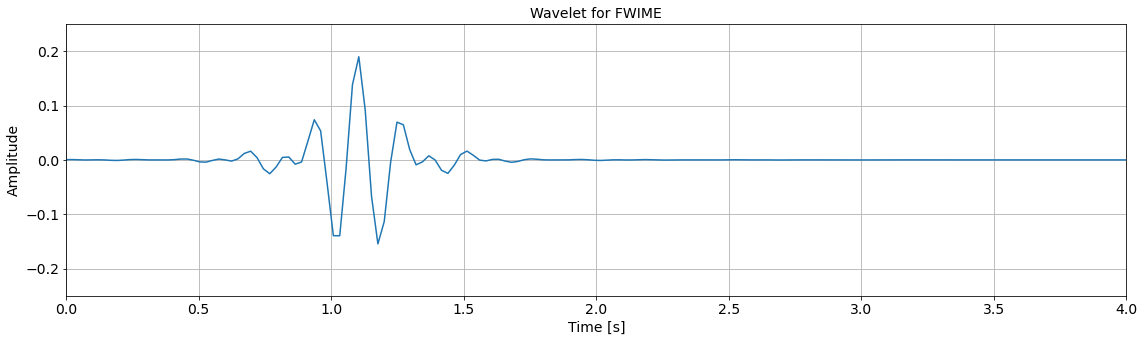

In [19]:
# Read wavelet
wav_fwime_3_9 = genericIO.defaultIO.getVector("wav/BP_North_Sea-fwime-wav-3-9.H")

# Get numpy arrays
wav_fwime_3_9_nd = wav_fwime_3_9.getNdArray()

# Get dimensions
wavelet_fwime_hyper = wav_fwime_3_9.getHyper()
time_axis_fwime = wavelet_fwime_hyper.getAxis(1)
nt_fwime = time_axis_fwime.n
ot_fwime = time_axis_fwime.o
dt_fwime = time_axis_fwime.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range_fwime = np.linspace(ot_fwime, ot_fwime+(nt_fwime-1)*dt_fwime, nt_fwime)
plt.plot(time_range_fwime, wav_fwime_3_9_nd)
plt.title('Wavelet for FWIME'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-0.25, 0.25])
plt.xlim([0, 4])
plt.grid()
plt.show()

In [21]:
%%bash

############### Create wavelet spectra ###############
Scale < wav/BP_North_Sea-fwime-wav-3-9.H | Spectra mag=dBnorm > wav/BP_North_Sea_fwime_temp_spec.H


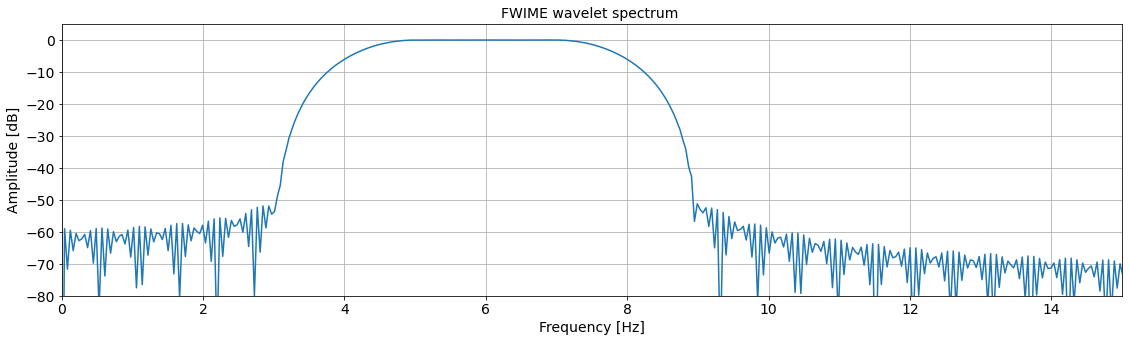

In [22]:
# Read spectra
spectra = genericIO.defaultIO.getVector("wav/BP_North_Sea_fwime_temp_spec.H")
spectra_Nd = spectra.getNdArray()
spectraHyper = spectra.getHyper()

# Read dimensions
freq_axis = spectraHyper.getAxis(1)
nf = freq_axis.n
of = freq_axis.o
df = freq_axis.d

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
freq_range = np.linspace(of, of+(nf-1)*df, nf)
plt.plot(freq_range, spectra_Nd.T)
plt.title('FWIME wavelet spectrum '), plt.xlabel("Frequency [Hz]"), plt.ylabel("Amplitude [dB]")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([-80, 5])
plt.xlim([0, 15])
plt.grid()
plt.show()

## Data 
* The frequency content is identical to the one used for the last band of conventional FWI


In [ ]:
%%bash

############ Data ############
${ACO_GPU_PACK}/bin/nonlinearPythonFloatMain.py par=par/BP_North_Sea-fwime-3-9.p vel=vel/BP_North_Sea-trueVel.pad.H model=wav/BP_North_Sea-fwime-wav-3-9.H data=dat/BP_North_Sea-fwime-data-3-9.H info=0 

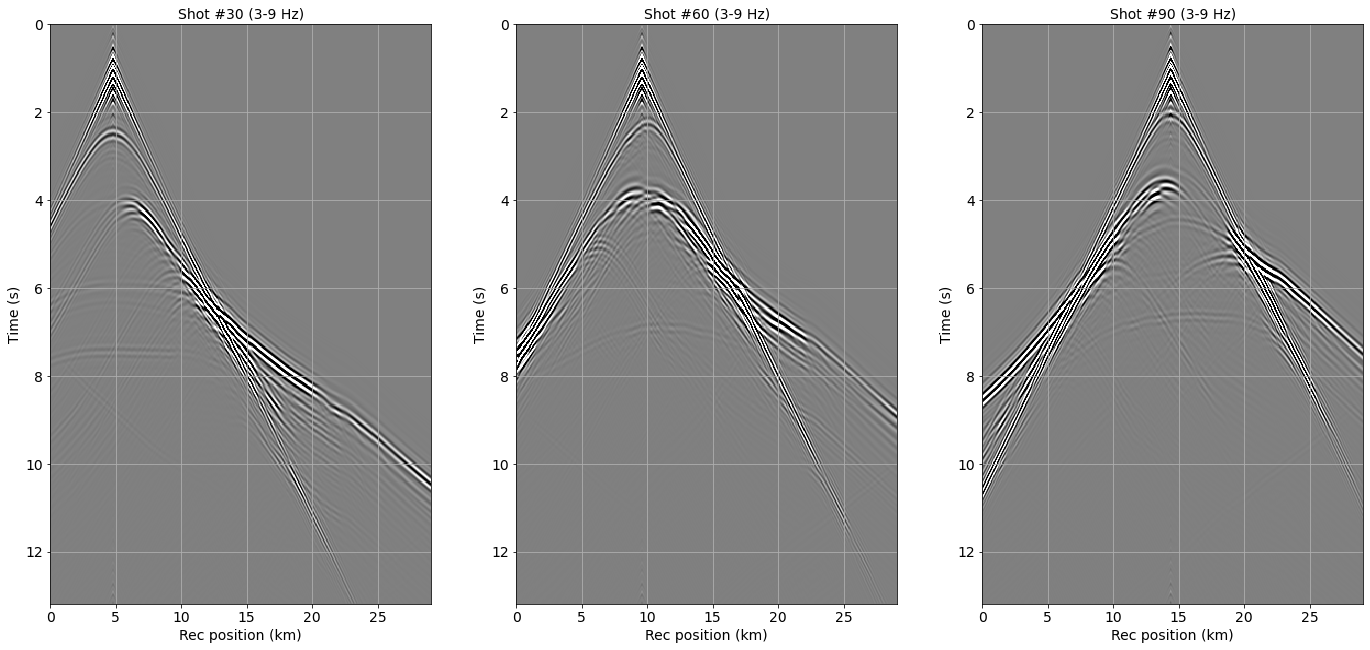

In [36]:
# Read data
data_3_9_fwime = genericIO.defaultIO.getVector("dat/BP_North_Sea-fwime-data-3-9.H")

# Display data
data_3_9_fwime_nd = data_3_9_fwime.getNdArray()

# Clipping
pclip=98
clip = np.percentile(np.abs(data_3_9_fwime_nd), pclip)

# Dimensions
o_rec_fwime = data_3_9_fwime.getHyper().getAxis(2).o
d_rec_fwime = data_3_9_fwime.getHyper().getAxis(2).d
n_rec_fwime = data_3_9_fwime.getHyper().getAxis(2).n
rec_range_fwime = np.linspace(o_rec_fwime, o_rec_fwime+(n_rec_fwime-1)*d_rec_fwime, n_rec_fwime)

# Display shot gathers
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

shot1 = 30
axs[0].pcolormesh(rec_range_fwime, time_range_fwime, data_3_9_fwime_nd[shot1].T,vmin=-clip,vmax=clip)
axs[0].invert_yaxis()
axs[0].grid()
axs[0].set_ylabel('Time (s)')
axs[0].set_xlabel('Rec position (km)')
axs[0].set_title('Shot #' + str(shot1) + " (3-9 Hz)")

shot2 = 60
axs[1].pcolormesh(rec_range_fwime, time_range_fwime, data_3_9_fwime_nd[shot2].T,vmin=-clip,vmax=clip)
axs[1].invert_yaxis()
axs[1].grid()
axs[1].set_ylabel('Time (s)')
axs[1].set_xlabel('Rec position (km)')
axs[1].set_title('Shot #' + str(shot2) + " (3-9 Hz)")

shot3 = 90
axs[2].pcolormesh(rec_range_fwime, time_range_fwime, data_3_9_fwime_nd[shot3].T,vmin=-clip,vmax=clip)
axs[2].invert_yaxis()
axs[2].grid()
axs[2].set_ylabel('Time (s)')
axs[2].set_xlabel('Rec position (km)')
axs[2].set_title('Shot #' + str(shot3) + " (3-9 Hz)")

plt.tight_layout(pad=3.0)
plt.show()

## Upper and lower velocity bounds computation
* We choose lower/upper velocity values $v_{min}$ and $v_{max}$ to prevent the velocity model from taking values that would create FD instability or dispersion
* However, the step length calculation and the model updates are conducted on the spline grid (see Barnier et al., 2022), so we need to express these bounds on the spline grid
* For each spline grid, we create two constant velocity models on the FD grid whose values are set to $v_{min}$ and $v_{max}$, respectively
* We map these constant velocity models onto the spline grid by applying the adjoint of the spline mapping operator
* We use the output of this adjoint mapping as lower/upper bounds on the spline grid (which is where our unknown model is parametrized)

In [ ]:
%%bash

################### Bounds for spline grid 1 ###################
# Max bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > temp/junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMax.H data=temp/junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMax.pad.H model=vel/BP_North_Sea-fwime-3-9-spline0-maxBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline0.p vel=vel/BP_North_Sea_velDummy.pad.H &&\

# Min bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > temp/junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMin.H data=temp/junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMin.pad.H model=vel/BP_North_Sea-fwime-3-9-spline0-minBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline0.p vel=vel/BP_North_Sea_velDummy.pad.H &&\

################### Bounds for spline grid 2 ###################
# Max bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > temp/junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMax.H data=temp/junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMax.pad.H model=vel/BP_North_Sea-fwime-3-9-spline1f-maxBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline1f.p vel=vel/BP_North_Sea_velDummy.pad.H &&\

# Min bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > temp/junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMin.H data=temp/junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMin.pad.H model=vel/BP_North_Sea-fwime-3-9-spline1f-minBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline1f.p vel=vel/BP_North_Sea_velDummy.pad.H &&\

################### Bounds for spline grid 3 ###################
# Max bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=5.0 > temp/junkMax.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMax.H data=temp/junkMax.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMax.pad.H model=vel/BP_North_Sea-fwime-3-9-spline3f-maxBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline3f.p vel=vel/BP_North_Sea_velDummy.pad.H &&\

# Min bound
Vel n1=140 n2=728 n3=1 d1=0.04 d2=0.04 d3=0.04 vc=1.3 > temp/junkMin.H &&\
${ACO_GPU_PACK}/bin/padFileGpuMain zPad=50 xPad=50 model=temp/junkMin.H data=temp/junkMin.pad.H &&\
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 data=temp/junkMin.pad.H model=vel/BP_North_Sea-fwime-3-9-spline3f-minBound.H adj=1 par=par/BP_North_Sea-fwime-3-9-spline3f.p vel=vel/BP_North_Sea_velDummy.pad.H 


## FWIME on spline grid 1

### Generate initial model onto first spline grid
* In step 2 of this notebook, we created/read the initial velocity model $\mathbf{m}^f_{init}$ defined on the (fine) FD grid 
* We now need to convert it (or map it) onto the first coarse spline grid $c_1$ in order to obtain the initial model for the FWIME inversion, $\mathbf{m}^{c_1}_{init}$
* The mapping is done by finding the unique minimizer of the following loss function:

$\mathbf{m}^{c_1}_{init} = \underset{\mathbf{m}^{c_1}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_1 \mathbf{m}^{c_1} - \mathbf{m}^f_{init} \right \|_2^2$
* $\mathbf{S}_1$ is the spline mapping operator (from the first coarse spline grid -> fine grid)
* $\mathbf{m}^{c_1}$ corresponds to any model defined on the first spline grid



In [ ]:
%%bash

# Create directory spline2dJunk (you might have to create it manually by typing "mkdir spline2dJunk")
# Map initial model onto the first spline grid
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_North_Sea_velDummy.pad.H data=vel/BP_North_Sea-initVel1.pad.H par=par/BP_North_Sea-fwime-3-9-spline0.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline0.H


### Launch inversion on spline grid 1
* Conduct 75 L-BFGS iterations on spline grid 1
* One L-BFGS iteration of FWIME takes approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs, so **100 hours** for 75 iterations

In [ ]:
%%bash

# Launch inversion on spline 1
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_North_Sea-fwime-3-9-spline0.p vel=vel/BP_North_Sea_velDummy.pad.H sources=wav/BP_North_Sea-fwime-wav-3-9.H data=dat/BP_North_Sea-fwime-data-3-9.H folderNl=inv/BP_North_Sea-fwime-3-9-spline0 modelCoarseInit=vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline0.H minBoundVector=vel/BP_North_Sea-fwime-3-9-spline0-minBound.H maxBoundVector=vel/BP_North_Sea-fwime-3-9-spline0-maxBound.H epsilon=0.8e-5 sloth=0

## FWIME on spline grid 2

### Map inverted model: spline 1 -> spline 2
* The output of FWIME on the first spline grid $\mathbf{m}^{c_1}_{final}$ is mapped onto the FD grid:

$\mathbf{m}^f_{1} = \mathbf{S}_1 \mathbf{m}^{c_1}_{final}$

* Then, the analogous inversion procedure as the one done in the previous step is employed to map this model on the second spline grid:

$\mathbf{m}^{c_2}_{init} = \underset{\mathbf{m}^{c_2}}{\mathrm{argmin}} \; \dfrac{1}{2} \left \| \mathbf{S}_2 \mathbf{m}^{c_2} - \mathbf{m}^f_{1} \right \|_2^2$


In [ ]:
%%bash

Window3d n3=1 f3=0 < inv/BP_North_Sea-fwime-3-9-spline0/BP_North_Sea-fwime-3-9-spline0_inv_mod.H > temp/junk1.H &&\
# Map inverted model from spline 0 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_North_Sea_velDummy.pad.H model=temp/junk1.H data=inv/BP_North_Sea-fwime-inv-mod-spline0.pad.H adj=0 par=par/BP_North_Sea-fwime-3-9-spline0.p &&\
# Map inverted model from FD grid -> spline 1f
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_North_Sea_velDummy.pad.H data=vel/BP_North_Sea-fwime-inv-mod-spline0.pad.H par=par/BP_North_Sea-fwime-3-9-spline1f.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline1f.H


### Launch inversion on spline grid 2
* Conduct 60 L-BFGS iterations on spline grid 2
* One L-BFGS iteration of FWIME takes approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs, so **80 hours** for 60 iterations

In [ ]:
%%bash

# Launch inversion on spline 2
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_North_Sea-fwime-3-9-spline1f.p vel=vel/BP_North_Sea_velDummy.pad.H sources=wav/BP_North_Sea-fwime-wav-3-9.H data=dat/BP_North_Sea-fwime-data-3-9.H folderNl=inv/BP_North_Sea-fwime-3-9-spline1f modelCoarseInit=vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline1f.H minBoundVector=vel/BP_North_Sea-fwime-3-9-spline1f-minBound.H maxBoundVector=vel/BP_North_Sea-fwime-3-9-spline1f-maxBound.H epsilon=1.75e-5 sloth=0

## FWIME on spline grid 3

### Map inverted model on spline 2 -> spline 3

In [ ]:
%%bash

# Extract inverted model
Window3d n3=1 f3=0 < inv/BP_North_Sea-fwime-3-9-spline1f/BP_North_Sea-fwime-3-9-spline1f_inv_mod.H > temp/junk1.H &&\
# Map inverted model from spline 1f -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_North_Sea_velDummy.pad.H model=temp/junk1.H data=vel/BP_North_Sea-fwime-inv-mod-spline1f.pad.H adj=0 par=par/BP_North_Sea-fwime-3-9-spline1f.p &&\
# Map inverted model from FD grid -> spline 3f
${ACO_GPU_PACK}/bin/interpBSplineInvMain.py nDim=2 nIter=50 folder=spline2dJunk vel=vel/BP_North_Sea_velDummy.pad.H data=vel/BP_North_Sea-fwime-inv-mod-spline1f.pad.H par=par/BP_North_Sea-fwime-3-9-spline3f.p &&\
Cp spline2dJunk/spline2dJunk_inv_mod.H vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline3f.H

### Launch inversion on spline grid 3
* Conduct 35 L-BFGS iterations on spline grid 3
* One L-BFGS iteration of FWIME take approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs, so **40 hours** for 35 iterations

In [ ]:
%%bash

# Launch inversion on spline 3
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_North_Sea-fwime-3-9-spline3f.p vel=vel/BP_North_Sea_velDummy.pad.H sources=wav/BP_North_Sea-fwime-wav-3-9.H data=dat/BP_North_Sea-fwime-data-3-9.H folderNl=inv/BP_North_Sea-fwime-3-9-spline3f modelCoarseInit=vel/BP_North_Sea-fwime-3-9-coarseInitMod-spline3f.H minBoundVector=vel/BP_North_Sea-fwime-3-9-spline3f-minBound.H maxBoundVector=vel/BP_North_Sea-fwime-3-9-spline3f-maxBound.H epsilon=1.75e-5 sloth=0

## FWIME on spline grid 4 (FD grid)

### Map inverted model on spline 3 -> spline 4

In [ ]:
%%bash

Window3d n3=1 f3=0 < inv/BP_North_Sea-fwime-3-9-spline3f/BP_North_Sea-fwime-3-9-spline3f_inv_mod.H > temp/junk1.H &&\
# Map inverted model from spline 3 -> FD grid
${ACO_GPU_PACK}/bin/interpBSplineMain.py nDim=2 vel=vel/BP_North_Sea_velDummy.pad.H model=temp/junk1.H data=vel/BP_North_Sea-fwime-3-9-coarseInitMod-noSpline.H adj=0 par=par/BP_North_Sea-fwime-3-9-spline3f.p

### Launch inversion on fourth spline grid (FD grid)
* Conduct 80 L-BFGS iterations on spline grid 4 (FD grid)
* One L-BFGS iteration of FWIME takes approximately 80 minutes on 4 x V100 Tesla NVIDIA GPUs, so **100 hours** for 80 iterations

In [ ]:
%%bash

# Launch inversion on spline 4 (FD grid)
${ACO_GPU_PACK}/bin/fwimeMain.py par=par/BP_North_Sea-fwime-3-9-noSpline.p vel=vel/BP_North_Sea_velDummy.pad.H sources=wav/BP_North_Sea-fwime-wav-3-9.H data=dat/BP_North_Sea-fwime-data-3-9.H folderNl=inv/BP_North_Sea-fwime-3-9-noSpline modelCoarseInit=vel/BP_North_Sea-fwime-3-9-coarseInitMod-noSpline.H minBound=1.3 maxBound=5.0 epsilon=1.75e-5 sloth=0

### Remarks:
* The $\epsilon$-value in unchanged across the inversion procedure
* The fourth spline grid coincides with the FD grid ($\mathbf{S}_4 = \mathbf{I}_d$)

# 4. FWIME results analysis

## FWIME objective functions

### Concatenate all components of objective functions

In [ ]:
%%bash

# Concatenate all objective functions components?   
Cat axis=1 inv/BP_North_Sea-fwime-3-9-spline0/BP_North_Sea-fwime-3-9-spline0_obj.H inv/BP_North_Sea-fwime-3-9-spline1f/BP_North_Sea-fwime-4-13-spline1f_obj.H inv/BP_North_Sea-fwime-3-9-spline3f/BP_North_Sea-fwime-3-9-spline3f_obj.H inv/BP_North_Sea-fwime-3-9-noSpline/BP_North_Sea-fwime-3-9-noSpline_obj.H > inv/BP_North_Sea_fwime_obj_total.H &&\
Cat axis=1 inv/BP_North_Sea-fwime-3-9-spline0/BP_North_Sea-fwime-3-9-spline0_obj_comp1.H inv/BP_North_Sea-fwime-3-9-spline1f/BP_North_Sea-fwime-4-13-spline1f_obj_comp1.H inv/BP_North_Sea-fwime-3-9-spline3f/BP_North_Sea-fwime-3-9-spline3f_obj_comp1.H inv/BP_North_Sea-fwime-3-9-noSpline/BP_North_Sea-fwime-3-9-noSpline_obj_comp1.H > inv/BP_North_Sea_fwime_obj_data.H &&\
Cat axis=1 inv/BP_North_Sea-fwime-3-9-spline0/BP_North_Sea-fwime-3-9-spline0_obj_comp1.H inv/BP_North_Sea-fwime-3-9-spline1f/BP_North_Sea-fwime-4-13-spline1f_obj_comp2.H inv/BP_North_Sea-fwime-3-9-spline3f/BP_North_Sea-fwime-3-9-spline3f_obj_comp2.H inv/BP_North_Sea-fwime-3-9-noSpline/BP_North_Sea-fwime-3-9-noSpline_obj_comp2.H > inv/BP_North_Sea_fwime_obj_annihilator.H

### Read and display objective function

In [ ]:
# Read FWIME objective functions

# Components of objective function
fwime_obj_total = genericIO.defaultIO.getVector("inv/BP_North_Sea_fwime_obj_total.H")
fwime_obj_data = genericIO.defaultIO.getVector("inv/BP_North_Sea_fwime_obj_data.H")
fwime_obj_annihilator = genericIO.defaultIO.getVector("inv/BP_North_Sea_fwime_obj_annihilator.H")

# Convert from SEP arrays to numpy arrays
fwime_obj_total_nd = fwime_obj_total.getNdArray()
fwime_obj_data_nd = fwime_obj_data.getNdArray()
fwime_obj_annihilator_nd = fwime_obj_annihilator.getNdArray()

# Plot normalized objective function
fwime_obj_total_norm = fwime_obj_total_nd/fwime_obj_total_nd[0]
fwime_obj_data_norm = fwime_obj_data_nd/fwime_obj_total_nd[0]
fwime_obj_annihilator_norm = fwime_obj_annihilator_nd/fwime_obj_total_nd[0]
plt.figure(figsize=(10,4))

# Display wavelets in time
fig, ax = plt.subplots(figsize=(19,5))
time_range = np.linspace(ot, ot+(nt-1)*dt, nt)
plt.plot(fwime_obj_total_norm)
plt.plot(fwime_obj_data_norm)
plt.plot(fwime_obj_annihilator_norm)
plt.title('FWIME objective function'), plt.xlabel("Iteration #"), plt.ylabel("Normalized objective function value")
ax.autoscale(enable=True, axis='x', tight=True)
plt.ylim([0 1])
plt.xlim([0, 300])
plt.grid()
plt.show()



## Inverted velocity models

In [ ]:
%%bash

# Extract and crop inverted models on each spline grids
Window3d n1=140 f1=55 n2=728 f2=55 < vel/BP_North_Sea-fwime-inv-mod-spline0.pad.H > vel/BP_North_Sea-fwime-inv-mod-spline0.H &&\ 
Window3d n1=140 f1=55 n2=728 f2=55 < vel/BP_North_Sea-fwime-inv-mod-spline1f.pad.H > vel/BP_North_Sea-fwime-inv-mod-spline1f.H &&\
Window3d n1=140 f1=55 n2=728 f2=55 < vel/BP_North_Sea-fwime-3-9-coarseInitMod-noSpline.H > vel/BP_North_Sea-fwime-inv-mod-spline3f.H &&\
Window3d n1=140 f1=55 n2=728 f2=55 < inv/BP_North_Sea-fwime-3-9-noSpline/BP_North_Sea-fwime-3-9-noSpline_inv_mod.H > vel/BP_North_Sea-fwime-inv-mod-noSpline.H 

In [ ]:
# Read inverted models
vel_true = genericIO.defaultIO.getVector("vel_non_repro/BP_North_Sea-trueVel.H")
vel_init = genericIO.defaultIO.getVector("vel_non_repro/BP_North_Sea-initVel1.H")
model_fwi = genericIO.defaultIO.getVector("inv/BP_North_Sea_inv_mod_3_9.H")
model_fwime_s1 = genericIO.defaultIO.getVector("vel/BP_North_Sea-fwime-inv-mod-spline0.H")
model_fwime_s2 = genericIO.defaultIO.getVector("vel/BP_North_Sea-fwime-inv-mod-spline1f.H")
model_fwime_s3 = genericIO.defaultIO.getVector("vel/BP_North_Sea-fwime-inv-mod-spline3f.H")
model_fwime_noSpline = genericIO.defaultIO.getVector("vel/BP_North_Sea-fwime-inv-mod-noSpline.H")
vel_target = genericIO.defaultIO.getVector("vel_paper/BP_North_Sea_fwime_vel_target.H")

# Get numpy array + hypecube info
vel_target_nd = vel_target.getNdArray()

# # Convert to numpy arrays
vel_true_nd = vel_true.getNdArray()
vel_init_nd = vel_init.getNdArray()
model_fwi_nd = model_fwi.getNdArray()
model_fwime_s1_nd = vel_true.getNdArray()
model_fwime_s2_nd = vel_true.getNdArray()
model_fwime_s3_nd = vel_true.getNdArray()
model_fwime_noSpline_nd = vel_true.getNdArray()
vel_target_nd = vel_target.getNdArray()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plot initial velocity model
img0_0 = axs[0,0].imshow(vel_init_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,0].set_title("Initial model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_0, ax=axs[0,0], orientation="horizontal", label="vel [km/s]")
axs[0,0].grid()
# plt.show()

# Plot FWI velocity model
img0_1 = axs[0,1].imshow(model_fwi_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[0,1].set_title("FWI 3-9 Hz"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img0_1, ax=axs[0,1], orientation="horizontal", label="vel [km/s]")
axs[0,1].grid()
# plt.show()

# Plot FWIME spline 1 velocity model
img1_0 = axs[1,0].imshow(model_fwime_s1_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME spline 1"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot final FWIME model
img1_0 = axs[1,0].imshow(model_fwime_noSpline_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("Final FWIME inverted model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot target FWIME velocity model (the model shown in the paper)
img1_0 = axs[1,0].imshow(vel_target_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[1,0].set_title("FWIME target model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img1_0, ax=axs[1,0], orientation="horizontal", label="vel [km/s]")
axs[1,0].grid()
# plt.show()

# Plot true velocity model
img2_1 = axs[2,1].imshow(vel_true_nd.T,cmap='jet', vmin=vel_true_nd.min(), vmax=vel_true_nd.max(), extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz), aspect=1.5)
axs[2,1].set_title("True model"), plt.xlabel("x [km]"), plt.ylabel("z [km]")
fig.colorbar(img2_1, ax=axs[2,1], orientation="horizontal", label="vel [km/s]")
axs[2,1].grid()
# plt.show()

plt.tight_layout()




## 5. References

* Barnier, G., 2022, Full waveform inversion by model extension: a robust method to estimate the seismic propagation in the subsurface from recorded seismograms: Ph.D. thesis, Stanford University.
* Barnier, G., E. Biondi, R. G. Clapp, and B. Biondi, 2022, Full waveform inversion by model extension: practical applications (manuscript submitted to Geophysics)
* Billette, F., and S. Brandsberg-Dahl, 2005, The 2004 bp velocity benchmark: 67th EAGE Conference & Exhibition, European Association of Geoscientists & Engineers, cp–1.
